# SIFT
In this notebook, we'll try to reproduce the results of Podlejski et al. (2023) who used SIFT to track the algae:

"SIFT was used to extract key points for describing aggregates shape based on Terra and Aqua AFAI images. Using these key points, the best subset of congruent linear 2D translations (no scaling, no rotation) was extracted, and averaged to compute the corresponding Sargassum velocity (see Appendix B). Then, OF algorithm was applied to confirm SIFT results. Inconsistent cases between the drift directions estimated from SIFT and OF were rejected, i.e., when the absolute angle between the estimated directions was larger than 25◦. We retained velocity from SIFT as it was found more robust than OF."

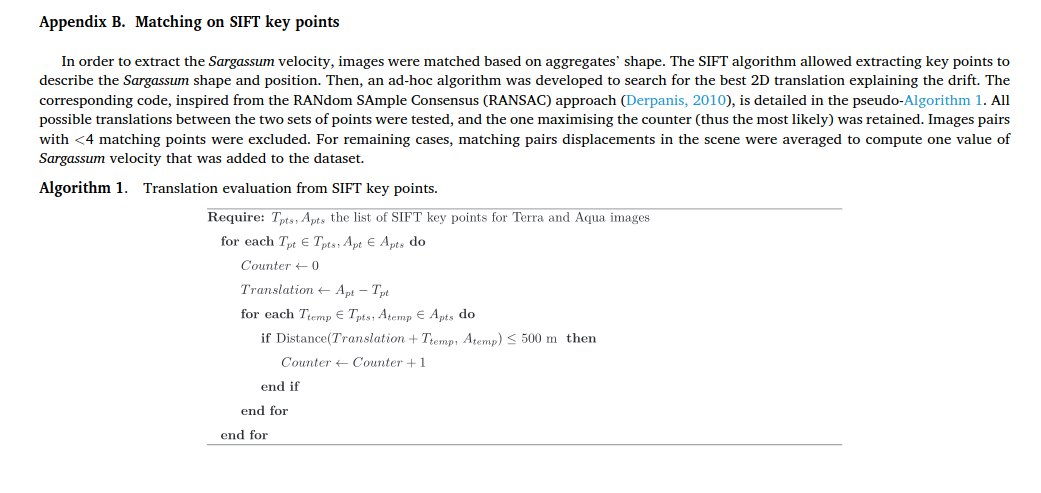

## Importing necessary libraries and notebooks

In [ ]:
import xarray as xr
import io
import os
import cv2
import imageio
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import numpy as np
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from datetime import datetime, timedelta
from matplotlib import ticker
from IPython.display import Image, display
from PIL import Image as PILImage


# Append the parent directory (Sargassum) to the system path
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), os.pardir)))
# Import the other notebooks without running their cells
from i_Getting_Started import visualize
from ii_Data_Manipulation import visualize_4
from iii_GOES_average import time_list, visualize_aggregate, calculate_median
from iv_Image_Processing import collect_times, crop_image, save_aggregate, binarize_image, bilateral_image, process_dates, process_directory
from v_i_OF_Functions import *

## SIFT Algorithm

### sift_features

In [ ]:
def sift_features(image):
    """
    Detects SIFT features and computes descriptors.

    :param image: The input image.
    :return: Keypoints and descriptors.
    """
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    sift = cv2.SIFT_create()
    keypoints, descriptors = sift.detectAndCompute(gray, None)
    return keypoints, descriptors

### match_sift_features
The FLANN based matcher is non deterministic so this doesn't always return the same result.

In [ ]:
def match_sift_features(desc1, desc2):
    """
    Matches SIFT features using FLANN-based matcher.

    :param desc1: Descriptors from the first image.
    :param desc2: Descriptors from the second image.
    :return: Good matches.
    """
    index_params = dict(algorithm=1, trees=5)
    search_params = dict(checks=50)
    flann = cv2.FlannBasedMatcher(index_params, search_params)
    matches = flann.knnMatch(desc1, desc2, k=2)
    
    good_matches = []
    for m, n in matches:
        # Lowe's Ratio Test
        if m.distance < 0.7 * n.distance:
            good_matches.append(m)
    
    return good_matches

### compute_translation
Podlejski used a threshold of 500 meters.

In [ ]:
def compute_translation(matches, kp1, kp2, spatial_resolution, threshold=500):
    """
    Computes the best translation vector using a RANSAC-like approach.

    :param matches: Good matches between keypoints.
    :param kp1: Keypoints from the first image.
    :param kp2: Keypoints from the second image.
    :param spatial_resolution: Spatial resolution of the image in meters per pixel.
    :param threshold: Distance threshold for considering a match valid in meters.
    :return: Best translation vector in pixels and in meters.
    """
    # Convert the threshold from meters to pixels
    threshold_pixels = threshold / spatial_resolution
    
    translations = []
    for match in matches:
        pt1 = kp1[match.queryIdx].pt
        pt2 = kp2[match.trainIdx].pt
        translation = (pt2[0] - pt1[0], pt2[1] - pt1[1])
        translations.append(translation)
    
    best_translation = None
    max_inliers = 0
    
    for trans in translations:
        inliers = 0
        for match in matches:
            pt1 = kp1[match.queryIdx].pt
            pt2 = kp2[match.trainIdx].pt
            estimated_pt2 = (pt1[0] + trans[0], pt1[1] + trans[1])
            distance = np.sqrt((estimated_pt2[0] - pt2[0])**2 + (estimated_pt2[1] - pt2[1])**2)
            if distance <= threshold_pixels:
                inliers += 1
        if inliers > max_inliers:
            max_inliers = inliers
            best_translation = trans
    
    if best_translation:
        best_translation_meters = (best_translation[0] * spatial_resolution, best_translation[1] * spatial_resolution)
        return best_translation, best_translation_meters
    else:
        return None, None

### draw_matches

In [ ]:
def draw_matches(prev_img, next_img, kp1, kp2, matches):
    """
    Draw matches between keypoints in two images.

    :param prev_img: The first image.
    :param next_img: The second image.
    :param kp1: Keypoints from the first image.
    :param kp2: Keypoints from the second image.
    :param matches: Good matches between the keypoints.
    """
    # Draw matches using OpenCV's drawMatches function
    img_matches = cv2.drawMatches(prev_img, kp1, next_img, kp2, matches, None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
    
    # Add a vertical line to separate the two images
    height, width1 = prev_img.shape[:2]
    width2 = next_img.shape[1]
    separator_line_position = width1
    
    # Draw the line on the image
    img_matches = cv2.line(img_matches, (separator_line_position, 0), (separator_line_position, height), (255, 0, 0), 2)
    
    # Plot the image with matches and the separating line
    plt.figure(figsize=(20, 10))
    plt.imshow(img_matches)
    plt.title("SIFT Feature Matches")
    plt.show()

### 23/07 - 24/07

In [ ]:
if __name__ == "__main__":
    # Load the images
    prev_img = cv2.imread("/home/yahia/Documents/Jupyter/Sargassum/Images/ABI_Averages_Processed_Viridis/Processed_algae_distribution_20220723.png")
    next_img = cv2.imread("/home/yahia/Documents/Jupyter/Sargassum/Images/ABI_Averages_Processed_Viridis/Processed_algae_distribution_20220724.png")
    
    # Detect SIFT features and compute descriptors
    kp1, desc1 = sift_features(prev_img)
    kp2, desc2 = sift_features(next_img)
    
    # Match SIFT features
    matches = match_sift_features(desc1, desc2)
    
    # Draw matches
    draw_matches(prev_img, next_img, kp1, kp2, matches)
    
    # Compute the best translation vector
    spatial_resolution = 1000  # Spatial resolution in meters per pixel for ABI-GOES
    # Compute the best translation vector
    best_translation, best_translation_meters = compute_translation(matches, kp1, kp2, spatial_resolution)
    print("Best translation vector (pixels):", best_translation)
    print("Best translation vector (meters):", best_translation_meters)
    
    # Compute Sargassum velocity (assuming a time interval of 1 day between images)
    if best_translation_meters:
        sargassum_velocity = np.linalg.norm(best_translation_meters)
        print("Sargassum velocity (meters/day):", sargassum_velocity)
    else:
        print("No valid translation vector found.")

At this scale and colormap and on this particular date, we can see that SIFT performs very badly.

In [ ]:
# Binarized
if __name__ == "__main__":
    # Load the images
    prev_img = cv2.imread("/media/yahia/ballena/ABI/ABI_Averages_Antilles_Binarized_Bilateral_Negative/Processed_algae_distribution_20220723.png")
    next_img = cv2.imread("/media/yahia/ballena/ABI/ABI_Averages_Antilles_Binarized_Bilateral_Negative/Processed_algae_distribution_20220724.png")
    
    # Detect SIFT features and compute descriptors
    kp1, desc1 = sift_features(prev_img)
    kp2, desc2 = sift_features(next_img)
    
    # Match SIFT features
    matches = match_sift_features(desc1, desc2)
    
    # Draw matches
    draw_matches(prev_img, next_img, kp1, kp2, matches)
    
    # Compute the best translation vector
    spatial_resolution = 1000  # Spatial resolution in meters per pixel for ABI-GOES
    # Compute the best translation vector
    best_translation, best_translation_meters = compute_translation(matches, kp1, kp2, spatial_resolution)
    print("Best translation vector (pixels):", best_translation)
    print("Best translation vector (meters):", best_translation_meters)
    
    # Compute Sargassum velocity (assuming a time interval of 1 day between images)
    if best_translation_meters:
        sargassum_velocity = np.linalg.norm(best_translation_meters)
        print("Sargassum velocity (meters/day):", sargassum_velocity)
    else:
        print("No valid translation vector found.")

Even with the binarized version, the algorithm still performs very badly (even worse). We should try changing the scale.

### Zoom

In [ ]:
if __name__ == "__main__":
    # Load the images
    prev_img = cv2.imread("/media/yahia/ballena/ABI/Spiral/ABI_Averages_Spiral_Processed/Processed_algae_distribution_20220723.png")
    next_img = cv2.imread("/media/yahia/ballena/ABI/Spiral/ABI_Averages_Spiral_Processed/Processed_algae_distribution_20220724.png")
    
    # Detect SIFT features and compute descriptors
    kp1, desc1 = sift_features(prev_img)
    kp2, desc2 = sift_features(next_img)
    
    # Match SIFT features
    matches = match_sift_features(desc1, desc2)
    
    # Draw matches
    draw_matches(prev_img, next_img, kp1, kp2, matches)
    
    # Compute the best translation vector
    spatial_resolution = 1000  # Spatial resolution in meters per pixel for ABI-GOES
    # Compute the best translation vector
    best_translation, best_translation_meters = compute_translation(matches, kp1, kp2, spatial_resolution)
    print("Best translation vector (pixels):", best_translation)
    print("Best translation vector (meters):", best_translation_meters)
    
    # Compute Sargassum velocity (assuming a time interval of 1 day between images)
    if best_translation_meters:
        sargassum_velocity = np.linalg.norm(best_translation_meters)
        print("Sargassum velocity (meters/day):", sargassum_velocity)
    else:
        print("No valid translation vector found.")

In [ ]:
# Binarized
if __name__ == "__main__":
    # Load the images
    prev_img = cv2.imread("/media/yahia/ballena/ABI/Spiral/ABI_Averages_Spiral_Binarized_Bilateral/Processed_algae_distribution_20220723.png")
    next_img = cv2.imread("/media/yahia/ballena/ABI/Spiral/ABI_Averages_Spiral_Binarized_Bilateral/Processed_algae_distribution_20220724.png")
    
    # Detect SIFT features and compute descriptors
    kp1, desc1 = sift_features(prev_img)
    kp2, desc2 = sift_features(next_img)
    
    # Match SIFT features
    matches = match_sift_features(desc1, desc2)
    
    # Draw matches
    draw_matches(prev_img, next_img, kp1, kp2, matches)
    
    # Compute the best translation vector
    spatial_resolution = 1000  # Spatial resolution in meters per pixel for ABI-GOES
    # Compute the best translation vector
    best_translation, best_translation_meters = compute_translation(matches, kp1, kp2, spatial_resolution)
    print("Best translation vector (pixels):", best_translation)
    print("Best translation vector (meters):", best_translation_meters)
    
    # Compute Sargassum velocity (assuming a time interval of 1 day between images)
    if best_translation_meters:
        sargassum_velocity = np.linalg.norm(best_translation_meters)
        print("Sargassum velocity (meters/day):", sargassum_velocity)
    else:
        print("No valid translation vector found.")

### Podlejski Example
We're going to test out our implementation of SIFT on the same example Podlejski used (Terra image at 14:26:08 and Aqua image at 17:31:44 both on 06/01/2021).

In [ ]:
path = "/media/yahia/ballena/CLS/modis-aqua-global-lr/cls-modis-aqua-global-lr_1d_20210106.nc"
visualize_4(path,(15.3,16.05),(-59.4,-58.5))
#visualize(path,(15.3,16.05),(-59.4,-58.5))
path = "/media/yahia/ballena/CLS/modis-aqua-global-lr/cls-modis-aqua-global-lr_1d_20210107.nc"
visualize_4(path,(15.3,16.05),(-59.4,-58.5))
Image(filename='/home/yahia/Documents/Jupyter/Sargassum/Images/Podlesjki_Aqua.png')

The image we have on the hard drive is a lower resolution version of the aqua image. We can see that there are a lot of details missing compared to the Podlejski version.